In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

NGRAMS = 2
SAMPLE = 1000000
EPOCHS = 15

# Florida voter
#df = pd.read_csv('/opt/names/fl_voter_reg/fl_reg_name_race.csv', nrows=SAMPLE)
df = pd.read_csv('../data/fl_voter_reg/fl_reg_name_race.csv')
df.dropna(subset=['name_first', 'name_last'], inplace=True)
sdf = df[df.race.isin(['multi_racial', 'native_indian']) == False].copy()

# Additional features
sdf['name_first'] = sdf.name_first.str.title()

sdf.groupby('race').agg({'name_first': 'count'})

,name_first
race,
asian,253808
hispanic,2179106
nh_black,1853690
nh_white,8757268


In [3]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

NGRAMS = 2
SAMPLE = 1000000
EPOCHS = 15

# Florida voter
#df = pd.read_csv('/opt/names/fl_voter_reg/fl_reg_name_race.csv', nrows=SAMPLE)
df = pd.read_csv('../data/fl_voter_reg/fl_reg_name_race.csv')
df.dropna(subset=['name_first', 'name_last'], inplace=True)


In [4]:
df

,name_last,name_suffix,name_first,name_middle,race
0,Walker,NaN,Elizabeth,A,nh_white
1,Palmer,NaN,Alton,Douglas,nh_white
2,Mc Cleod,NaN,Alicia,D,nh_black
3,Scarborough,NaN,Dale,Fredrick,nh_white
4,Walker,NaN,Daniel,Ray,nh_white
...,...,...,...,...,...
13184061,Walters,NaN,William,Walter,nh_white
13184062,Sawyer,NaN,Matthew,Lee,nh_white
13184063,Thomas,NaN,Janine,O'Riska,nh_white
13184064,Campbell,NaN,Angel,Rose,multi_racial


In [5]:
df.race.value_counts()

nh_white         8757268
hispanic         2179106
nh_black         1853690
asian             253808
multi_racial       94332
native_indian      45673
Name: race, dtype: int64

## Preprocessing the input data

In [2]:
# last name only
sdf['name_last_name_first'] = sdf['name_last']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.name_last_name_first)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.name_last_name_first.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.race.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

num_words = 1423
Max feature len = 29, Avg. feature len = 5


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [3]:
'''The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 20 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


10435097 train sequences
2608775 test sequences
Pad sequences (samples x time)
X_train shape: (10435097, 20)
X_test shape: (2608775, 20)
4 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (10435097, 4)
y_test shape: (2608775, 4)


In [ ]:
print('Build model...')

if True:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='sigmoid'))
if False:
    embedding_vecor_length = 32
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            45536     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 128,484.0
Trainable params: 128,484
Non-trainable params: 0.0
_________________________________________________________________
None


In [ ]:
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=2)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 9391587 samples, validate on 1043510 samples
Epoch 1/15
9327s - loss: 0.5831 - acc: 0.7875 - val_loss: 0.5530 - val_acc: 0.7974
Epoch 2/15
8846s - loss: 0.5660 - acc: 0.7935 - val_loss: 0.5482 - val_acc: 0.7991
Epoch 3/15
8893s - loss: 0.5644 - acc: 0.7940 - val_loss: 0.5467 - val_acc: 0.7997
Epoch 4/15
9716s - loss: 0.5644 - acc: 0.7942 - val_loss: 0.5473 - val_acc: 0.8004
Epoch 5/15
10582s - loss: 0.5647 - acc: 0.7939 - val_loss: 0.5475 - val_acc: 0.7999
Epoch 6/15
10171s - loss: 0.5655 - acc: 0.7937 - val_loss: 0.5471 - val_acc: 0.7995
Epoch 7/15
9842s - loss: 0.5665 - acc: 0.7934 - val_loss: 0.5487 - val_acc: 0.7993
Epoch 8/15
9756s - loss: 0.5699 - acc: 0.7921 - val_loss: 0.5509 - val_acc: 0.7986
Epoch 9/15
9398s - loss: 0.5707 - acc: 0.7918 - val_loss: 0.5580 - val_acc: 0.7960
Epoch 10/15


In [13]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.567388321827
Test accuracy: 0.792729921132


## Confusion Matrix

In [14]:
y_pred = model.predict_classes(X_test, verbose=2)
p = model.predict_proba(X_test, verbose=2) # to predict probability
target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

             precision    recall  f1-score   support

      asian       0.77      0.35      0.48     50762
   hispanic       0.80      0.81      0.80    435821
   nh_black       0.68      0.13      0.22    370738
   nh_white       0.80      0.94      0.86   1751454

avg / total       0.78      0.79      0.75   2608775

[[  17644    5860     620   26638]
 [   1169  350971    1782   81899]
 [   1025    7249   49136  313328]
 [   3224   77324   20603 1650303]]


## Save model

In [15]:
model.save('./models/fl_voter_reg/lstm/fl_all_ln_lstm.h5')

In [19]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./models/fl_voter_reg/lstm/fl_all_ln_vocab.csv', index=False, encoding='utf-8')

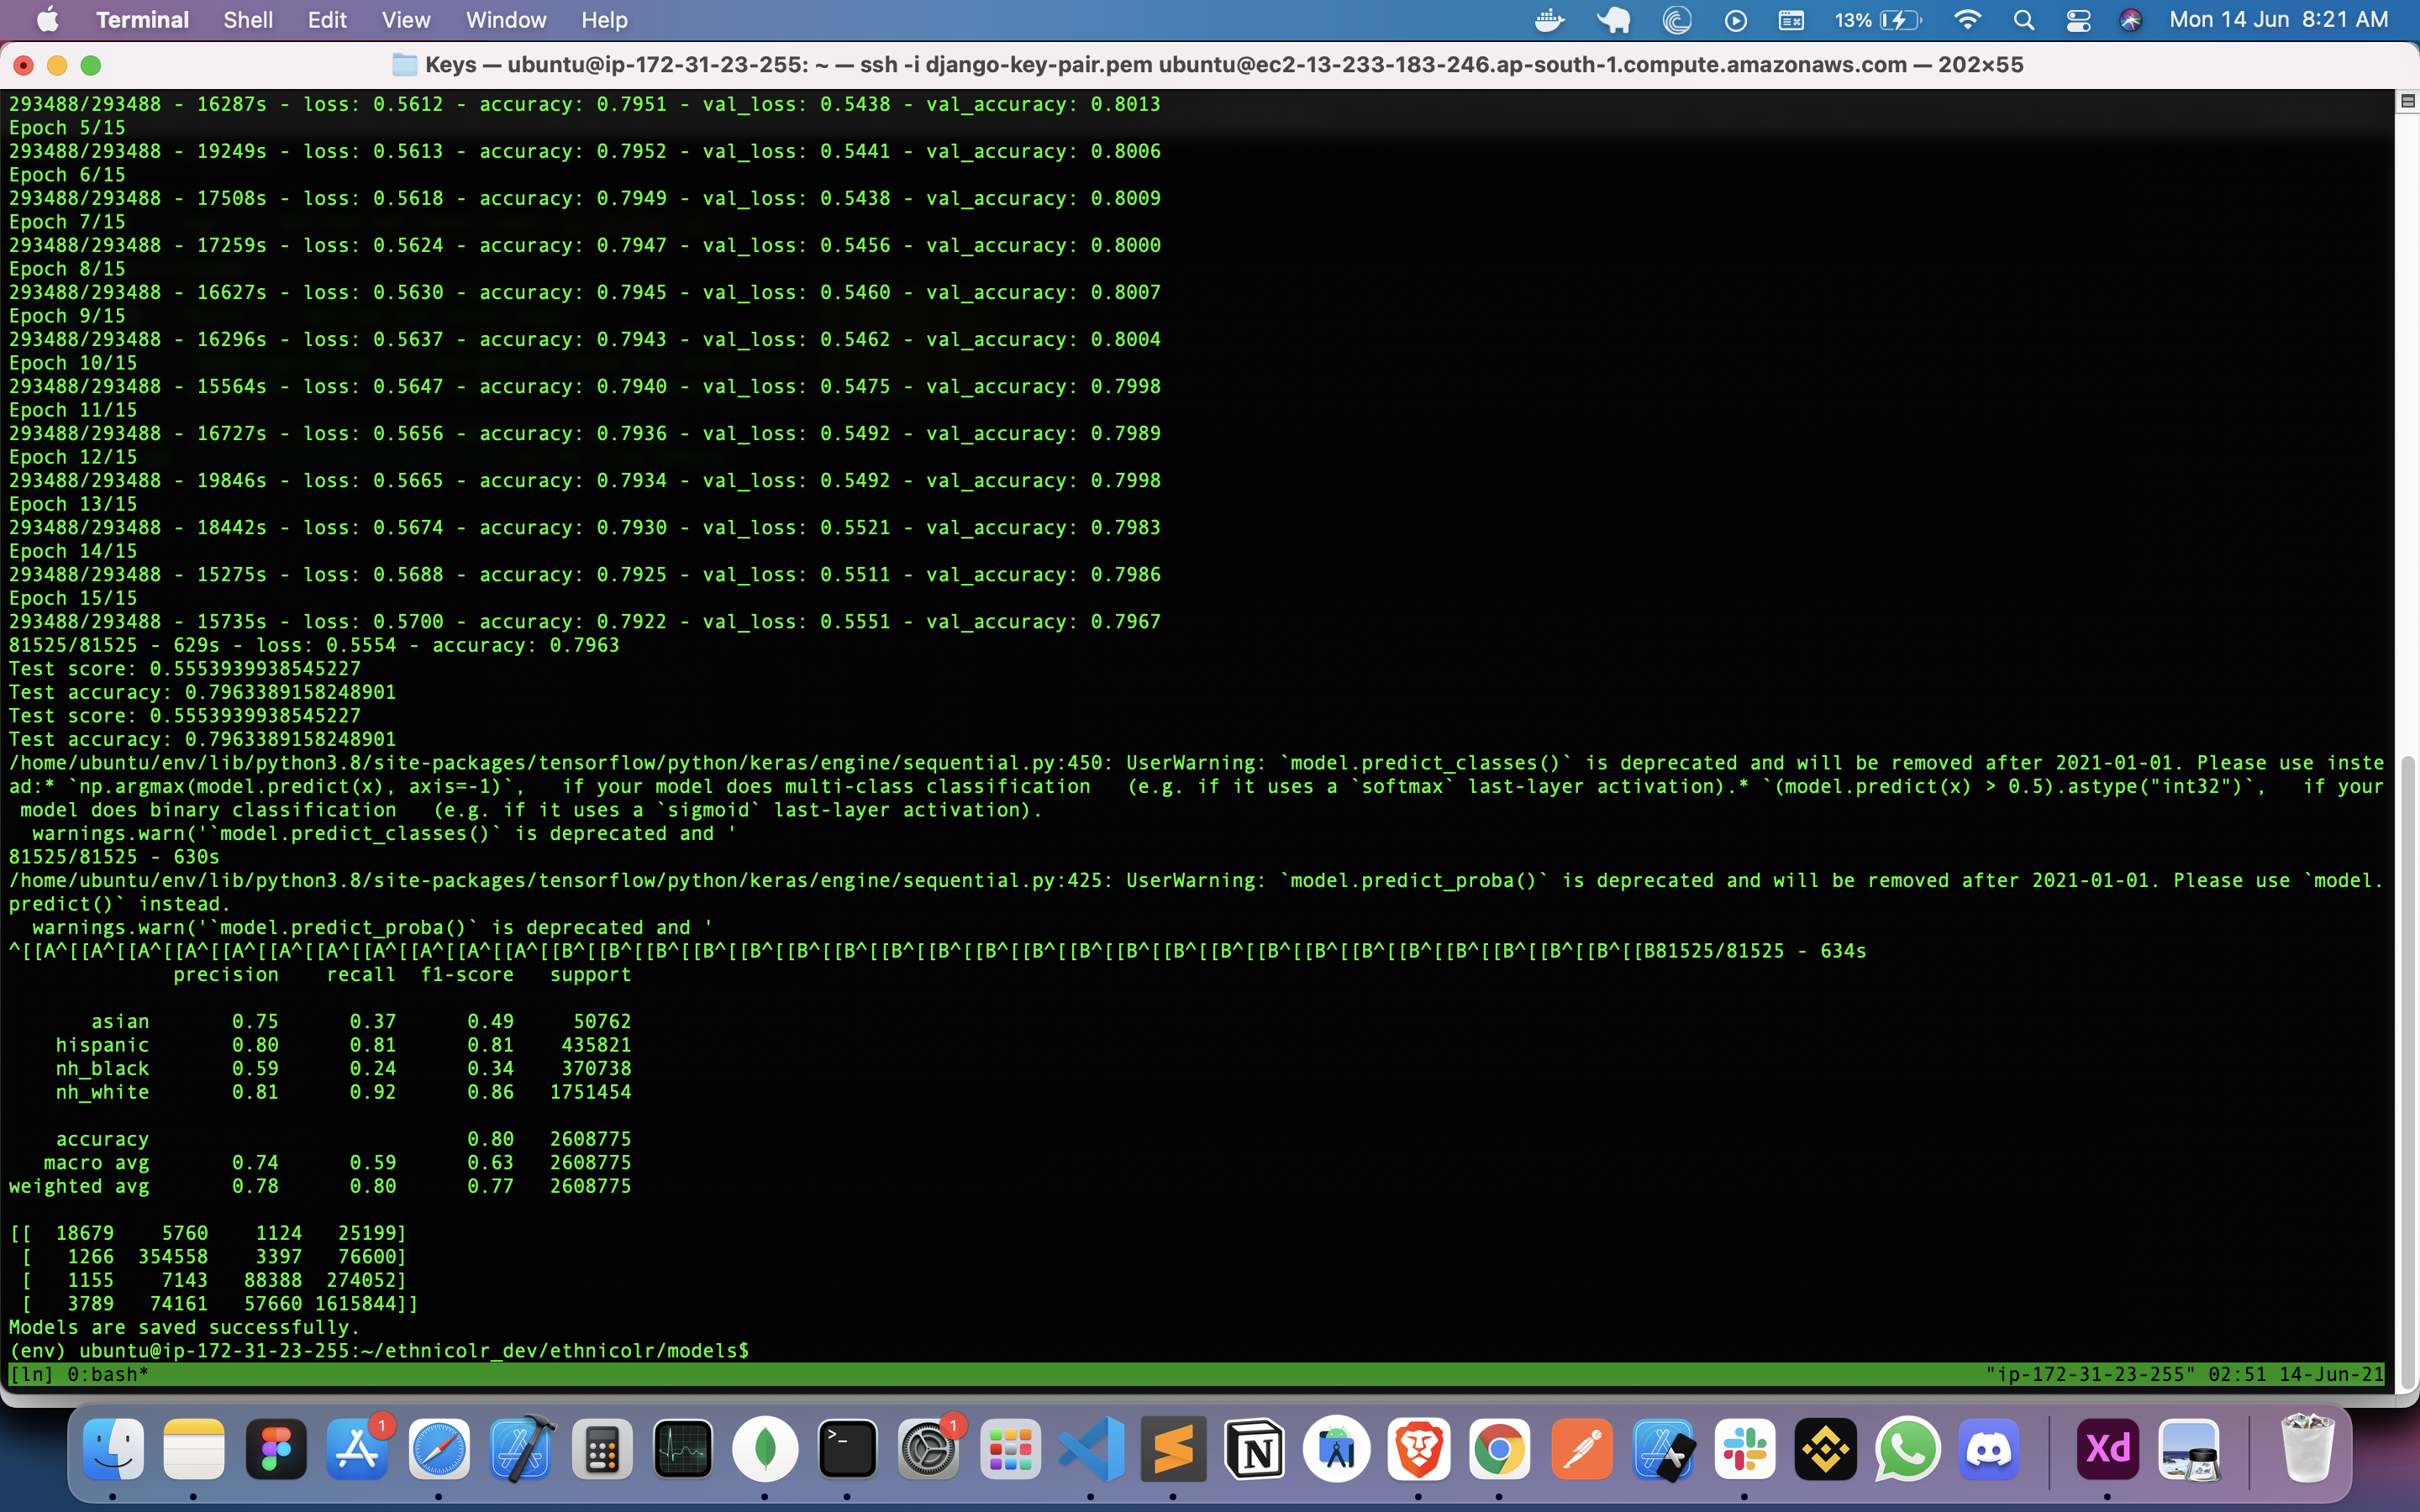

In [2]:
from IPython.display import Image
Image("training_fl_lastname.png")